In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
import os
from pathlib import Path
from os.path import join
import pandas as pd
import numpy as np
import numpy.ma as ma

from util.files import *
from util.const import *
from util.ddfs import *

In [76]:
# FIPS will be passed in as an argument, one day...
FIPS = '34007'
# STATE ABBR and NATION will be derived from FIPS, one day...
STATEABBR = 'NJ'
NATION = 'US'

# I think it also could make sense to pass in scenario and
# ddf type as arguments. For main results
# we're using 'mid' and 'naccs' but for generating
# our sensitivity analysis results we will need to pass
# in the other scenarios and 'hazus'
# Very well suited for snakemake :) 
SCENARIO = 'Mid'
DDF_TYPE = 'naccs'

# Load and Prepare Data

In [77]:
# Load the ensemble data, along with the optimal & dfe
# elevation results
opt_elev_filename = 'ens_opt_elev_' + DDF_TYPE + '_' + SCENARIO + '.pqt'
dfe_elev_filename = 'ens_dfe_elev_' + DDF_TYPE + '_' + SCENARIO + '.pqt'
ens_filename = 'ensemble_' + SCENARIO + '.pqt'

ens_df = pd.read_parquet(join(FO, ens_filename))
opt_elev_df = pd.read_parquet(join(EXP_DIR_I, FIPS, opt_elev_filename))
dfe_elev_df = pd.read_parquet(join(EXP_DIR_I, FIPS, dfe_elev_filename))

In [78]:
# Merge on fd_id and sow_ind to get eal_avoid, elev_cost, and opt_elev
# into the ensemble
ens_df = ens_df.merge(opt_elev_df,
                      on=['fd_id', 'sow_ind'],
                      suffixes=['','_opt'])
# Merge dfe_elev_df as well, adding suffixes
ens_df = ens_df.merge(dfe_elev_df,
                      on=['fd_id', 'sow_ind'],
                      suffixes=['','_dfe'])

In [79]:
# We also need to load in the links between structures and the
# social vulnerability data for sorting rules
sovi_filepath = join(VULN_DIR_I, 'social', FIPS, 'c_indicators.pqt')
sovi_df = pd.read_parquet(sovi_filepath)

# Merge these in later after we've aggregated ens_df on the
# column we're sorting on for these (npv_opt). The way the
# sorting will work for these is subset to communities that
# meet the indicator and then spend our budget based on
# npv_opt. 

In [80]:
# Calculate metrics for objectives that can be pre-calculated
# and aggregated later, and indicators for sorting

# Get the difference of benefits and costs
# NPV is an objective we are trying to maximize
ens_df['npv_opt'] = ens_df['pv_avoid'] - ens_df['pv_cost']

# Upfront cost is an objective we want to minimize
# This is respresented by elev_invst

# Residual flood risk is an objective we want to minimize
# This is represented by pv_resid

# The slope of residual relative flood risk 
# as a funciton of structure value is an objective we want as
# close to 0 as possible. In math, this is minimizing the
# absolute value of the slope. Values < 0 
# indicate that residual relative risk is a larger portion of
# structure value when structure value is higher. We interpret this
# as households with greater value have higher risk intensities, 
# but because they have higher values they have a better private
# ability to defend themselves
# So, we need to calculate residual relative flood risk as a portion
# of structure value. This is pv_resid/val_s. However, not
# every home will be elevated once we allocate funding. So, 
# residual risk could also be pv_base/val_s.
# This is the resid_rel_eal col

# We also want to follow the same logic as above for avoided
# losses. We can pre-calculate this because the numerator and
# denominator are the same, regardless of a sorting rule. We only
# assign this value when elevation is funded for the property. 
# It is 0 if elevation is not funded
# This is the avoid_rel_eal col

# To calculate the slope, we will take
# Where comp = ens_df.groupby('fd_id')[relavent_cols].mean()
# We will follow
# https://numpy.org/doc/stable/reference/
# generated/numpy.linalg.lstsq.html
# x = comp['val_s']
# A = np.vstack([x, np.ones(len(x))]).T
# y = comp['avoid_rel']
# m, c = np.linalg.lstsq(A, y, rcond=None)[0]


## Sorting rules
# BCR (highest to lowest)
ens_df['bcr_opt'] = ens_df['pv_avoid']/ens_df['pv_cost']

# Reduction in relative eal (highest to lowest)
# This is the avoid_rel column

# Reduction in residual risk (highest to lowest)
# This is the pv_resid column

# Elevation cost (lowest to highest)
# This is the elev_invst column

# Relative eal (highest to lowest)
ens_df['rel_eal'] = ens_df['base_eal']/ens_df['val_s']


# Allocate funding

In [145]:
# Now that we have these values we can start sorting! 

# We will sort until we expend our budget, which goes from 1 mil
# to 36 mil in investment costs in 5 mil increments
budgets = np.arange(1e6, 10e6, 1e5)

# We need to group by on fd_id and aggregate on our sorting columns
sub_cols = ['bcr_opt', 'pv_resid', 'npv_opt', 'fd_id',
            'resid_rel_eal', 'avoid_rel_eal', 'rel_eal', 'elev_invst',
            'val_s', 'pv_base']
sort_df = ens_df.groupby('fd_id')[sub_cols].mean()

# To calculate objectives
# npv_opt, elev_invst, pv_resid can all be aggregated from
# the values in sort_df (and how it is subsetted from funding
# allocation)
# avoid_rel can be used directly in the linalg.lstsq code
# need to define resid_rel based on which homes are selected

In [164]:
# Household based sorting

# Dict of sort keys to fd_id values
# We want to write out the ordering and
# the allocations
sort_dict = {}

# Columns we sort from top to bottom
h_sort_desc = ['npv_opt', 'avoid_rel_eal',
              'rel_eal']

# Columns we sort from bottom to top
h_sort_asc = ['elev_invst', 'pv_resid']

# Loop through ascending columns and sort, store in dict
for col in h_sort_desc:
    sort_dict[col] = sort_df[col].sort_values(ascending=False).index

# Loop through descending columns and sort, store in dict
for col in h_sort_asc:
    sort_dict[col] = sort_df[col].sort_values(ascending=True).index

# Community based sorting
sort_c_df = sort_df.join(sovi_df, how='inner')

# Columns for community sorting
c_sort_cols = ['lmi', 'sovi', 'ovb', 'cejst']

# Loop through these to subset, sort by npv_opt
# and follow the code from above
# Loop through ascending columns and sort, store in dict
# We add in the remaining observations in case we have
# budget left over
for col in c_sort_cols:
    sort_temp = sort_c_df[sort_c_df[col] == True]
    sort_pri = sort_temp['npv_opt'].sort_values(ascending=False).index
    sort_temp2 = sort_c_df[sort_c_df[col] == False]
    sort_slack = sort_temp2['npv_opt'].sort_values(ascending=False).index
    sort_dict[col] = sort_pri.join(sort_slack)

# Loop through budgets and the keys in sort_dict
# Calculate the elev_inst cumulative sum and subset to
# the value just under the budget
# Then calculate all of the objective values
# Store in a dict of
# sort_key_budget keys to objectives values
obj_dict = {}
for budget in budgets:
    for sort_col, fd_id in sort_dict.items():
        # Key for obj dict
        obj_key = sort_col + '_' + str(budget)
        # Sort our df according to the rule at hand
        sorted_df = sort_df.reindex(fd_id)

        # Calculate the cumulative sum of elev_inst
        sorted_df['policy_cost'] = sorted_df['elev_invst'].cumsum()

        # Subset df based on budget
        elevated = sorted_df[sorted_df['policy_cost'] <= budget]

        # Calculated objectives for the elevated df
        # We can simply aggregate 3 objectives
        npv = elevated['npv_opt'].sum()
        resid = elevated['pv_resid'].sum()
        up_cost = elevated['elev_invst'].sum()

        # We need to use linear algebra for the equity objectives
        # First, slope between reduced relative risk
        # and structure value
        x = elevated['val_s']/sort_df['val_s'].max()
        A = np.vstack([x, np.ones(len(x))]).T
        y = elevated['avoid_rel_eal']
        avoid_eq, c = np.linalg.lstsq(A, y, rcond=None)[0]

        # Second, slope between residual relative risk and structure
        # value. We want to do this for all of the houses
        # So, we need to go back to sort_df. For homes in sort_df
        # that are in elevated, we want to use their
        # pv_resid for "y". For homes that are not elevated, 
        # we want to use pv_base for "y".
        x = sort_df['val_s']/sort_df['val_s'].max()
        A = np.vstack([x, np.ones(len(x))]).T
        y = np.where(sort_df['fd_id'].isin(elevated['fd_id']),
                     sort_df['resid_rel_eal'],
                     sort_df['rel_eal'])
        resid_eq, c = np.linalg.lstsq(A, y, rcond=None)[0]

        # Store objectives in dict
        obj_dict[obj_key] = (npv, resid, up_cost,
                             np.abs(avoid_eq),
                             np.abs(resid_eq))

        print('Calculate objective values for policy:\n'+
              'Sort by ' + sort_col + '\nWith Budget of $M ' + str(budget))

Calculate objective values for policy:
Sort by npv_opt
With Budget of $M 1000000.0
Calculate objective values for policy:
Sort by avoid_rel_eal
With Budget of $M 1000000.0
Calculate objective values for policy:
Sort by rel_eal
With Budget of $M 1000000.0
Calculate objective values for policy:
Sort by elev_invst
With Budget of $M 1000000.0
Calculate objective values for policy:
Sort by pv_resid
With Budget of $M 1000000.0
Calculate objective values for policy:
Sort by lmi
With Budget of $M 1000000.0
Calculate objective values for policy:
Sort by sovi
With Budget of $M 1000000.0
Calculate objective values for policy:
Sort by ovb
With Budget of $M 1000000.0
Calculate objective values for policy:
Sort by cejst
With Budget of $M 1000000.0
Calculate objective values for policy:
Sort by npv_opt
With Budget of $M 1100000.0
Calculate objective values for policy:
Sort by avoid_rel_eal
With Budget of $M 1100000.0
Calculate objective values for policy:
Sort by rel_eal
With Budget of $M 1100000.0
C

In [165]:
# Let's take a look
objs = pd.DataFrame.from_dict(obj_dict).T.reset_index()
objs.columns =  ['policy', 'npv', 'pv_resid', 'up_cost',
                 'avoid_eq', 'resid_eq']
objs['sort'] = objs['policy'].str.split('_').str[:-1].apply(lambda x: '_'.join(x))
objs['budget'] = objs['policy'].str.split('_').str[-1].astype(float).astype(int)

# Add a community vs. household indicator
objs.loc[objs['sort'].isin(c_sort_cols), 'res'] = 'community'
objs.loc[~objs['sort'].isin(c_sort_cols), 'res'] = 'household'

(50000000.0, 75000000.0)

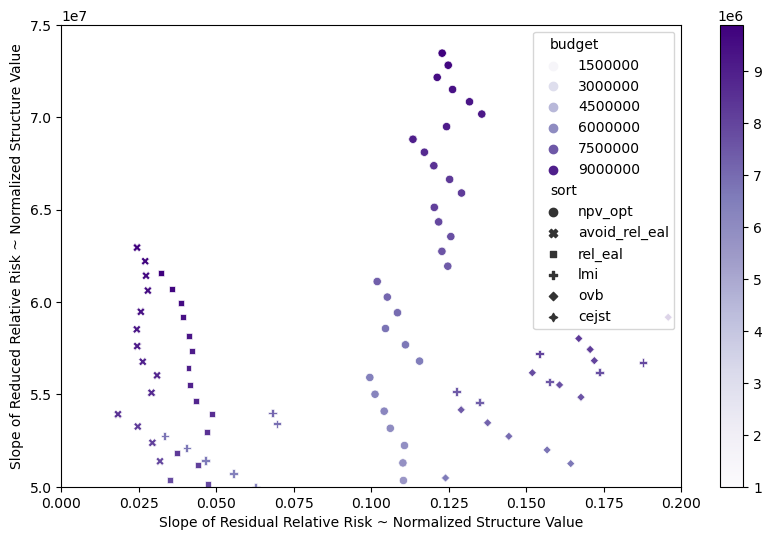

In [179]:
# Need to write out objs & sort_dict and do all the visualizations in 
# the Figures notebook (though it could be helpful to have
# a more exploratory version of Figures)